This notebook demonstrates performance of VAR model. Model's parameters can be changed in the corresponding sections here. Prediction performance only.

In [1]:
# add path to ssa package
import sys
sys.path.append('../../..')

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pathlib

import pickle

%matplotlib inline 

In [3]:
from statsmodels.tsa.api import VAR

In [4]:
# plot with large fonts and other stuff
from src.plot.journal_style import EnableJournalStylePlotting

# data extraction methods
import src.data.electricity as electricity_data

## Data preprocessing

In [5]:
# names of observed signals
sig_names = ['Production program', 'Price']
# measure units
sig_units = ['MhW', 'TL']

num_signals = 2

In [6]:
# retrive signals and corresponding time grids
# they are already preproccessed
(train_data, time_grid_train), (test_data, time_grid_test) = electricity_data.GetTrainTestData(
    series_len=3000,
    test_ratio=0.18
)

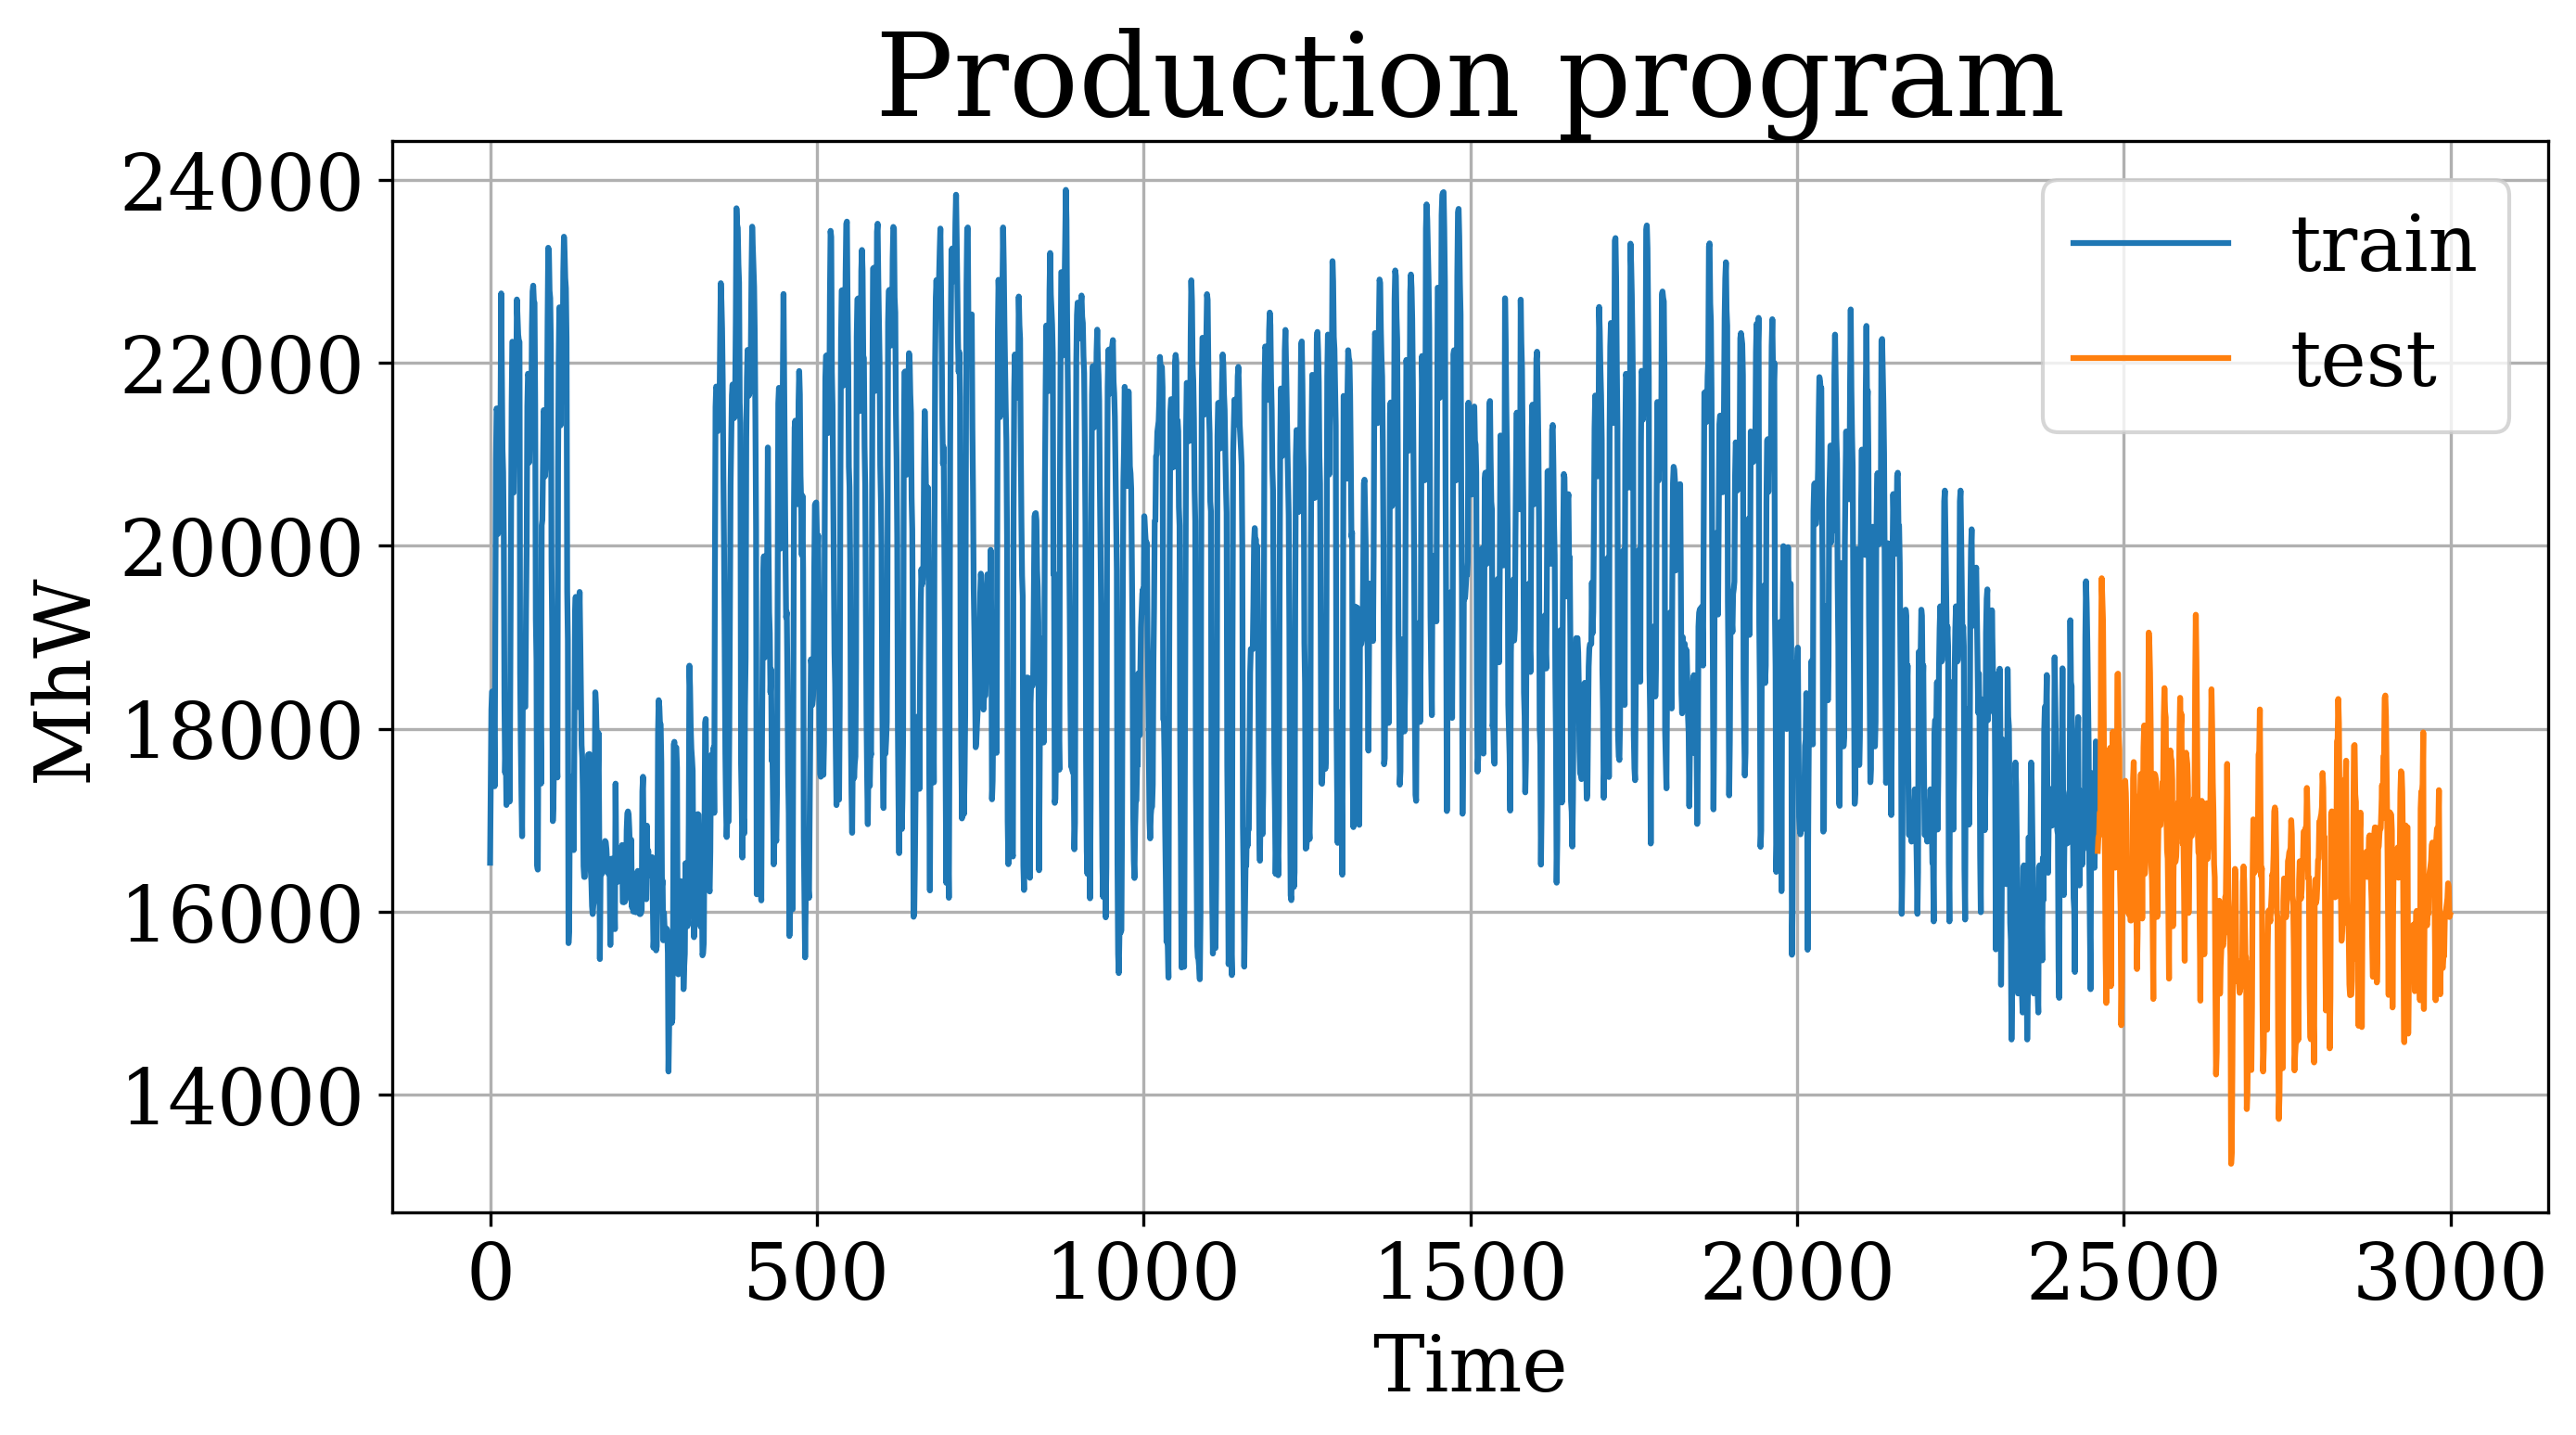

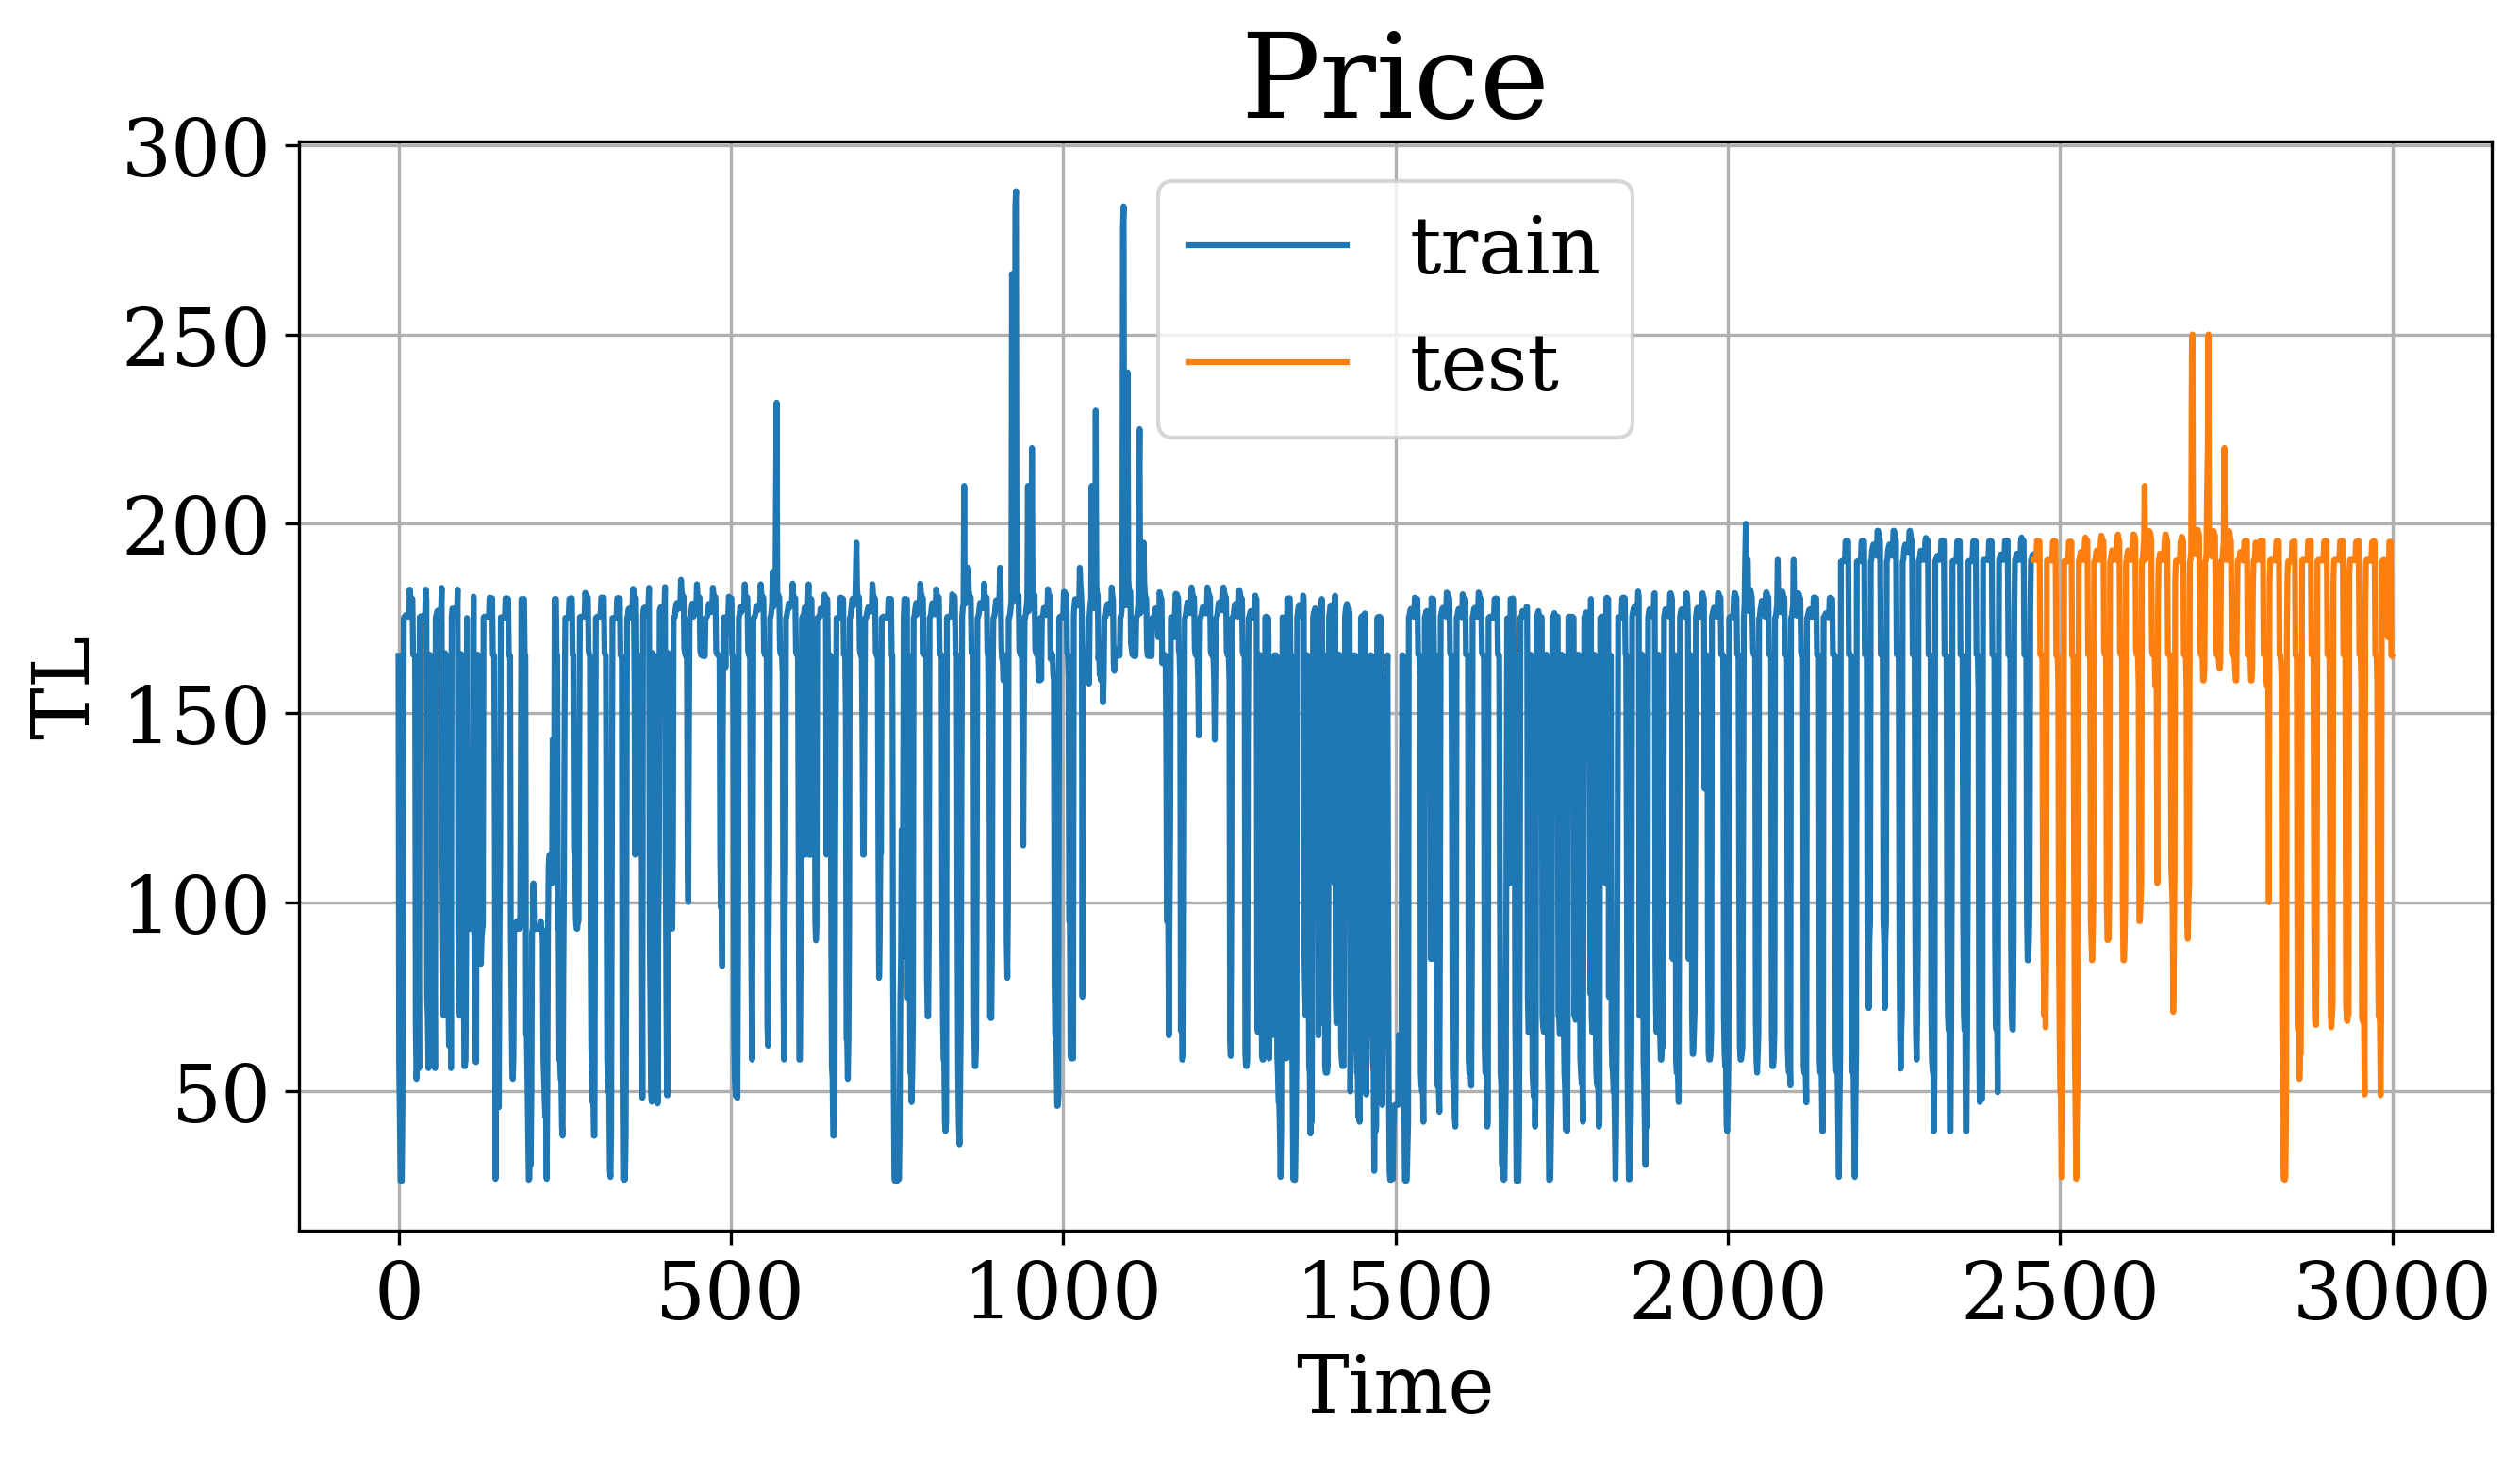

In [7]:
# draw signals
for i in range(num_signals):
    with EnableJournalStylePlotting():
        fig, ax = plt.subplots(figsize=(10, 5))

        ax.plot(time_grid_train, train_data.T[i], label='train')
        ax.plot(time_grid_test, test_data.T[i], label='test')

        ax.grid(True)
        ax.legend()
        ax.set_xlabel('Time')
        ax.set_ylabel(sig_units[i])
        ax.set_title(sig_names[i])

## Global method parameters

In [8]:
# for consitency along diffrent methods they share alike parameters
num_lags = 500

## VAR fitting

In [9]:
# make directory for models
pathlib.Path(f'./saved_model').mkdir(parents=True, exist_ok=True)

In [10]:
# load model if it already exists
if pathlib.Path(f'./saved_model/var_model.pkl').exists():
    with open(f'./saved_model/var_model.pkl', 'rb') as f:
        var_model = pickle.load(f)
else:
    var_model = VAR(train_data)

    var_result = var_model.fit(num_lags)

    # save model
    with open(f'./saved_model/var_model.pkl', 'wb') as f:
        pickle.dump(var_result, f)

In [11]:
var_result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 25, Mar, 2024
Time:                     22:00:25
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    24.8899
Nobs:                     1960.00    HQIC:                   21.2848
Log likelihood:          -22366.1    FPE:                2.66674e+08
AIC:                      19.1896    Det(Omega_mle):     1.16847e+08
--------------------------------------------------------------------
Results for equation y1
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const        -308.142854       809.925825           -0.380           0.704
L1.y1           0.839335         0.034155           24.574           0.000
L1.y2           2.100979         0.788780            2.664           0.008
L2.y1       

## Predicition

In [12]:
# colours for our signals (https://colorhunt.co/palette/7f27ff9f70fdfdbf60ff8911)
color_list = ['#7F27FF', '#FF8911', '#65B741']

In [13]:
# make directory for figures
pathlib.Path(f'./figs/prediction').mkdir(parents=True, exist_ok=True)

In [14]:
# obtain last num_lags values before test values to create forecast 
train_last_values = train_data[-num_lags:]
var_forecast = var_result.forecast(train_last_values, test_data.shape[0])

In [15]:
var_forecast.shape

(539, 2)

In [16]:
# count metrics
var_mse_metric = np.sum((var_forecast - test_data) ** 2)
var_mape_metric = np.sum(np.abs((var_forecast - test_data) / test_data))

print(f'MSE = {var_mse_metric}\nMAPE = {var_mape_metric}')

# create dataframe for metrics
metrics_frame = pd.DataFrame({'MSE': [var_mse_metric], 'MAPE': [var_mape_metric]}, index=['VAR']).to_csv()

MSE = 4214628988.6448073
MAPE = 268.0937783112209


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


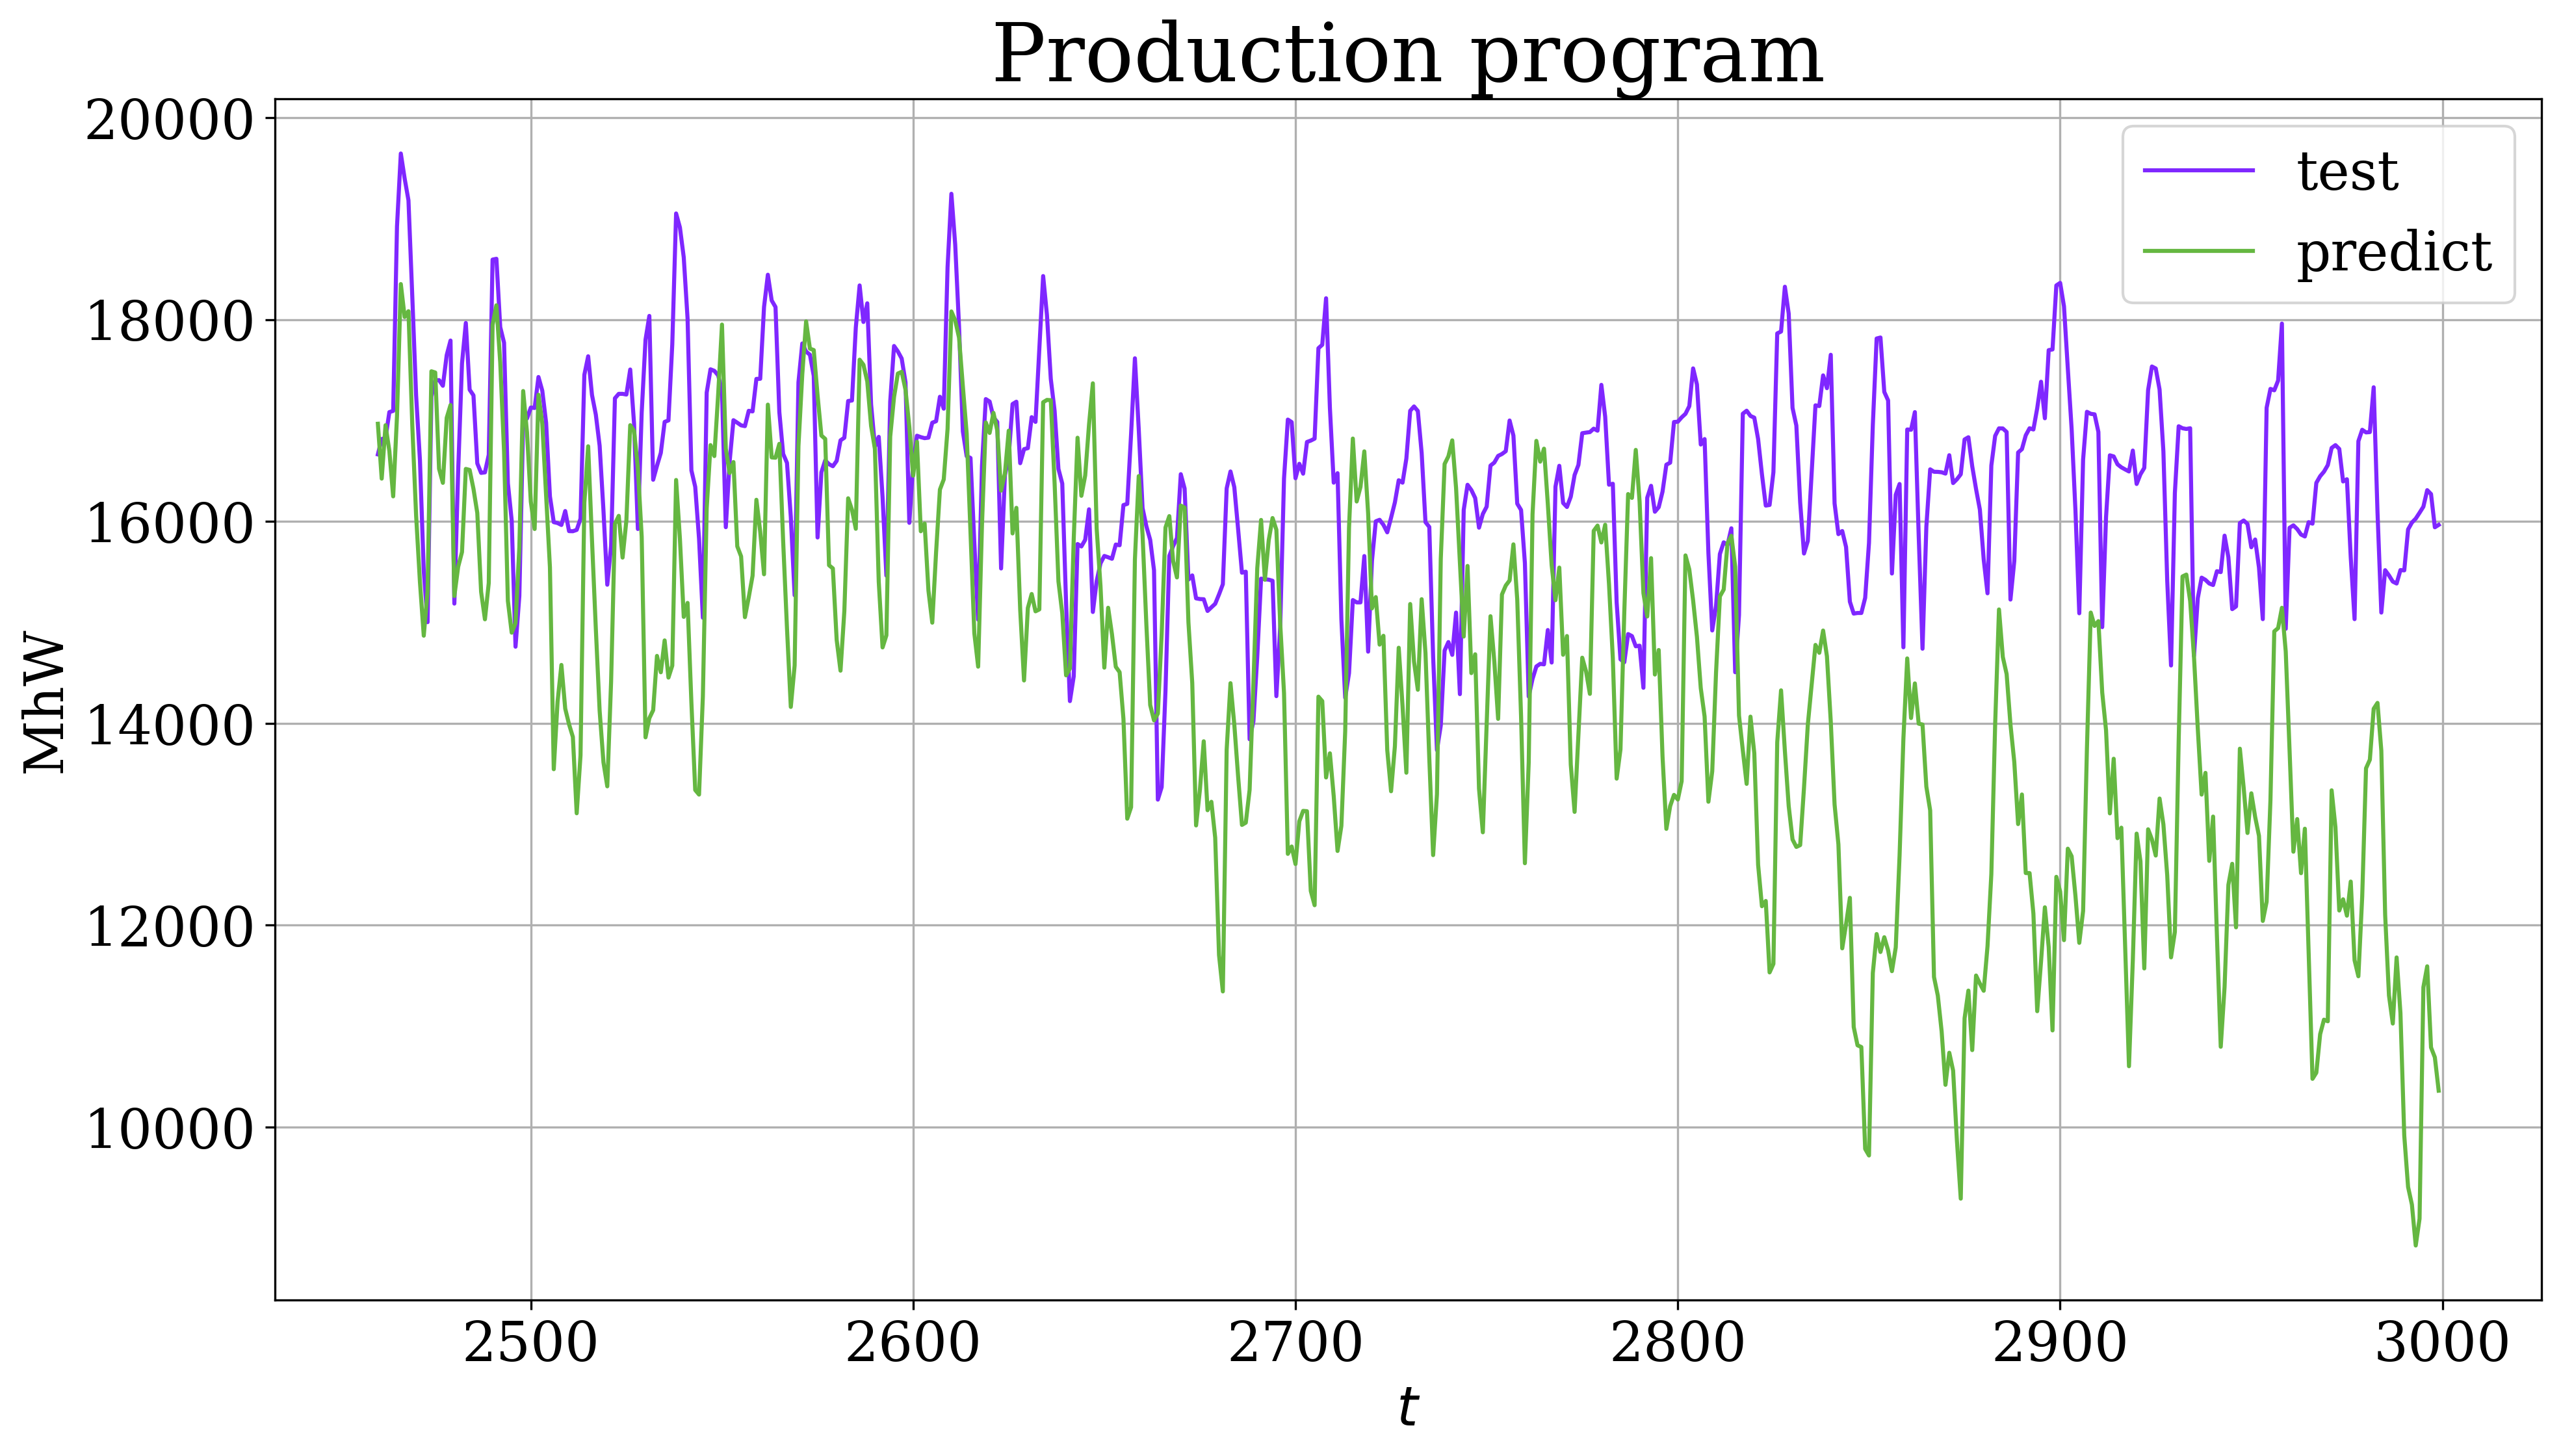

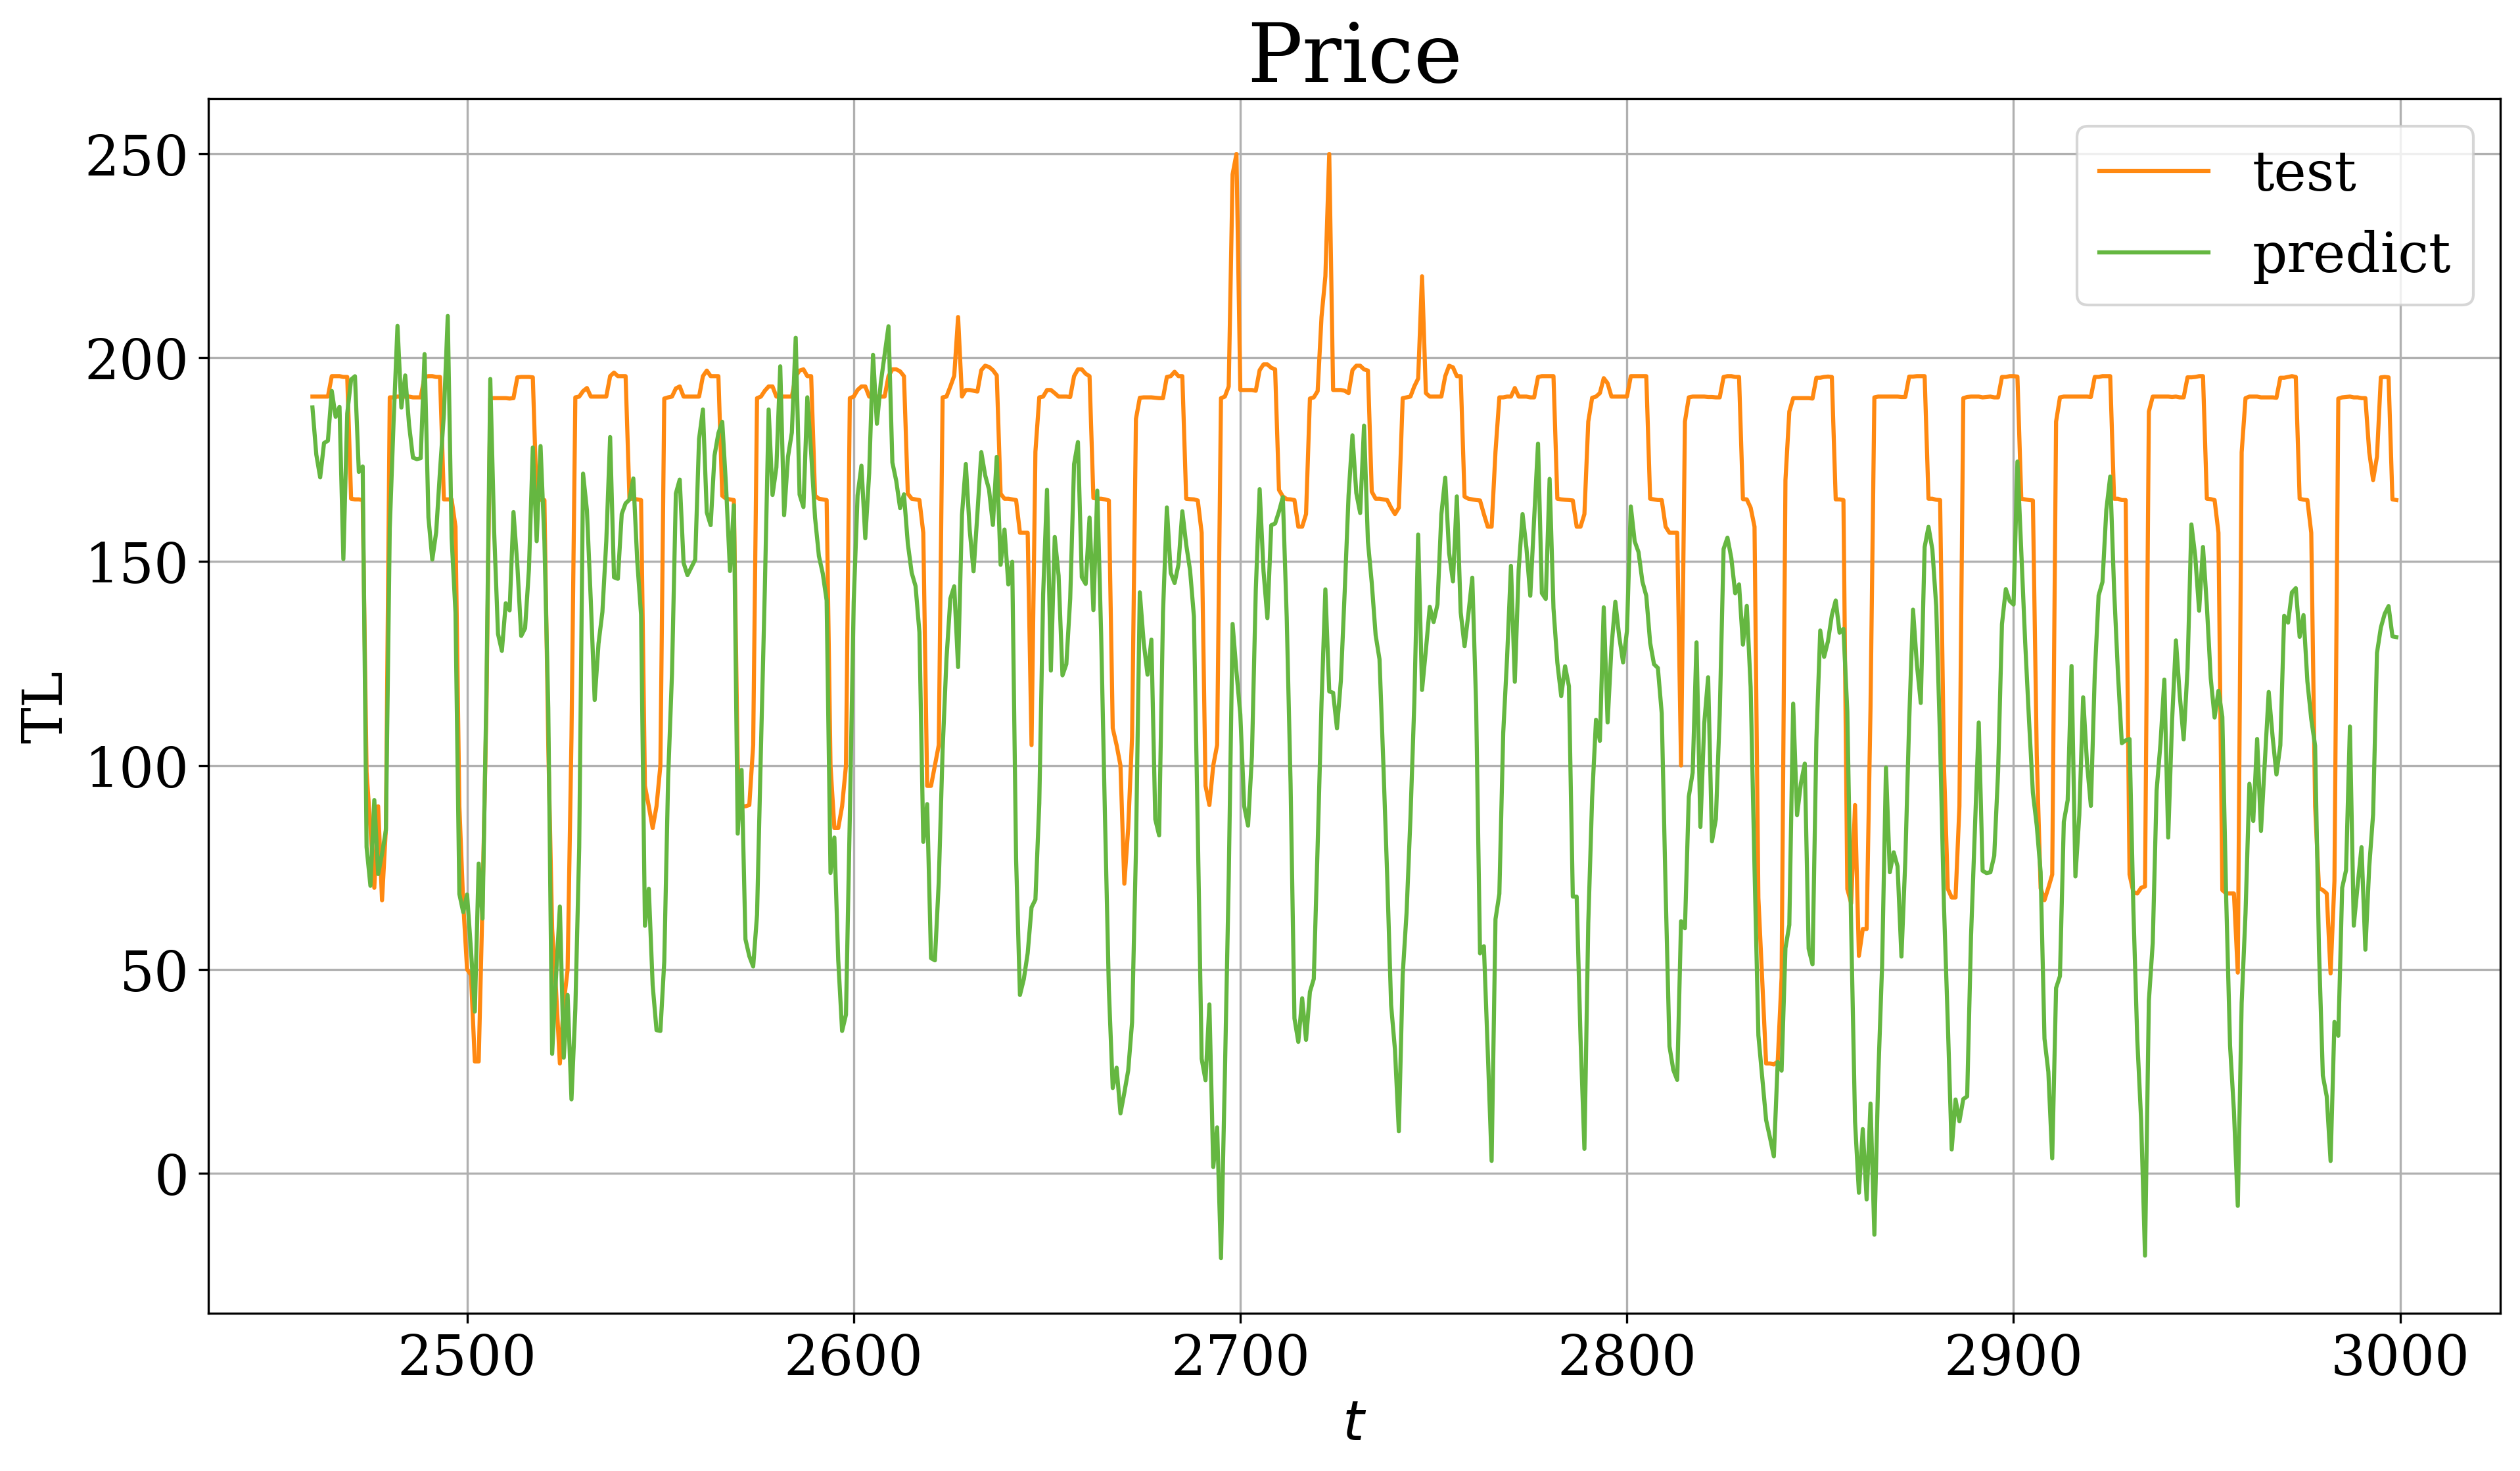

In [17]:
# plot prediction and real values
for i in range(test_data.shape[1]):
    with EnableJournalStylePlotting():
        fig, ax = plt.subplots(figsize=(15, 8))

        ax.plot(time_grid_test, test_data.T[i], color=color_list[i], label='test')
        ax.plot(time_grid_test, var_forecast.T[i], color=color_list[-1], label='predict')

        ax.grid(True)
        ax.legend();
        ax.set_ylabel(f'{sig_units[i]}', fontsize=20)
        ax.set_xlabel('$t$', fontsize=20)
        ax.set_title(f'{sig_names[i]}', fontsize=30)

        fig.savefig(f'./figs/prediction/{sig_names[i].replace(" ", "_")}.eps',
                             format='eps')